In [1]:
!pip install transformers
!pip install sentence-transformers

In [2]:
from transformers import RobertaTokenizer, T5ForConditionalGeneration

tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')
code_t5 = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-base-multi-sum')

In [3]:
summaries = []

def add_summary(text):
  input_ids = tokenizer(text, return_tensors="pt").input_ids
  generated_ids = code_t5.generate(input_ids, max_length=20)
  summary = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
  summaries.append(summary)

add_summary("""
def greet(name):
  print("Hello, " + name)
""")

add_summary("""
def greet(name = None):
  if name:
    print("Hello, " + name + "!")
  else:
    print("Hello, there!")
""")

add_summary("""
def svg_to_image(string, size=None):
    if isinstance(string, unicode):
        string = string.encode('utf-8')
        renderer = QtSvg.QSvgRenderer(QtCore.QByteArray(string))
    if not renderer.isValid():
        raise ValueError('Invalid SVG data.')
    if size is None:
        size = renderer.defaultSize()
        image = QtGui.QImage(size, QtGui.QImage.Format_ARGB32)
        painter = QtGui.QPainter(image)
        renderer.render(painter)
    return image
""")

add_summary("""
def greet(name, message="How are you today?"):
  print("Hello, " + name + "!")
  print(message)
""")

add_summary("""
def binary_search(arr, x):
    low = 0
    high = len(arr) - 1
    mid = 0
 
    while low <= high:
 
        mid = (high + low) // 2
 
        # If x is greater, ignore left half
        if arr[mid] < x:
            low = mid + 1
 
        # If x is smaller, ignore right half
        elif arr[mid] > x:
            high = mid - 1
 
        # means x is present at mid
        else:
            return mid
 
    # If we reach here, then the element was not present
    return -1
""")

# introduce some bugs:
add_summary("""
def binary_search(arr, x):
    low = 0
    high = len(arr) - 1
    mid = 0
 
    while low < high:
 
        mid = (high + low) // 2
 
        # If x is greater, ignore left half
        if arr[mid] < x:
            low = mid + 1
 
        # If x is smaller, ignore right half
        elif arr[mid] > x:
            high = mid - 1
 
        # means x is present at mid
        else:
            return mid
""")

# Bug 1
add_summary("""
def dist(x1, x2, y1, y2):
  return 45
""")

# Bug 2 - ingen roten ur
add_summary("""
def dist(x1, x2, y1, y2):
  return pow(x1-x2, 2) + pow(y1-y2, 2)
""")

# Bugfix
add_summary("""
def dist(x1, x2, y1, y2):
  return pow(pow(x1-x2, 2) + pow(y1-y2, 2), 0.5)
""")



print(summaries)

['Print a greet message.', 'Greet the name of the node.', 'Convert a SVG string to a QImage.', 'Greet a name and a message.', 'Binary search for a node in a list of node objects.', 'Binary search for a node in a list.', 'Return the distance between two points.', 'Distance between two points.', 'Return the distance between two points.']


In [4]:
from sentence_transformers import SentenceTransformer
sbert = SentenceTransformer('paraphrase-MiniLM-L6-v2')

embeddings = sbert.encode(summaries)

In [5]:
from scipy import spatial

# https://stackoverflow.com/questions/18424228/cosine-similarity-between-2-number-lists
def cosine_sim(v1, v2):
  return 1 - spatial.distance.cosine(v1, v2)

In [6]:
def compare(i, j):
  s1 = summaries[i]
  s2 = summaries[j]
  sim = cosine_sim(embeddings[i], embeddings[j])
  print(f""""{s1}" - "{s2}" """)
  print(f"Sim: {sim}\n")


In [7]:
compare(0, 0)
compare(0, 1)
compare(0, 2)
compare(1, 2)

compare(0, 3)
compare(1, 3)
compare(2, 3)

compare(3, 4)
compare(4, 5)

"Print a greet message." - "Print a greet message." 
Sim: 1.0

"Print a greet message." - "Greet the name of the node." 
Sim: 0.47729113698005676

"Print a greet message." - "Convert a SVG string to a QImage." 
Sim: 0.03276908025145531

"Greet the name of the node." - "Convert a SVG string to a QImage." 
Sim: 0.05006831884384155

"Print a greet message." - "Greet a name and a message." 
Sim: 0.7740920782089233

"Greet the name of the node." - "Greet a name and a message." 
Sim: 0.6289330720901489

"Convert a SVG string to a QImage." - "Greet a name and a message." 
Sim: -0.0017895839409902692

"Greet a name and a message." - "Binary search for a node in a list of node objects." 
Sim: 0.11252222210168839

"Binary search for a node in a list of node objects." - "Binary search for a node in a list." 
Sim: 0.9480828046798706



In [8]:
import pandas as pd
import numpy as np

In [9]:
def cosine_sims(embeddings):
  """ Beräkna cos-sim mellan alla embeddings som en numpy matris """
  sims = np.zeros((len(embeddings), len(embeddings)))
  for i in range(len(embeddings)):
    for j in range(len(embeddings)):
      s1 = summaries[i]
      s2 = summaries[j]
      sim = cosine_sim(embeddings[i], embeddings[j])
      sims[i][j] = sim
  return sims

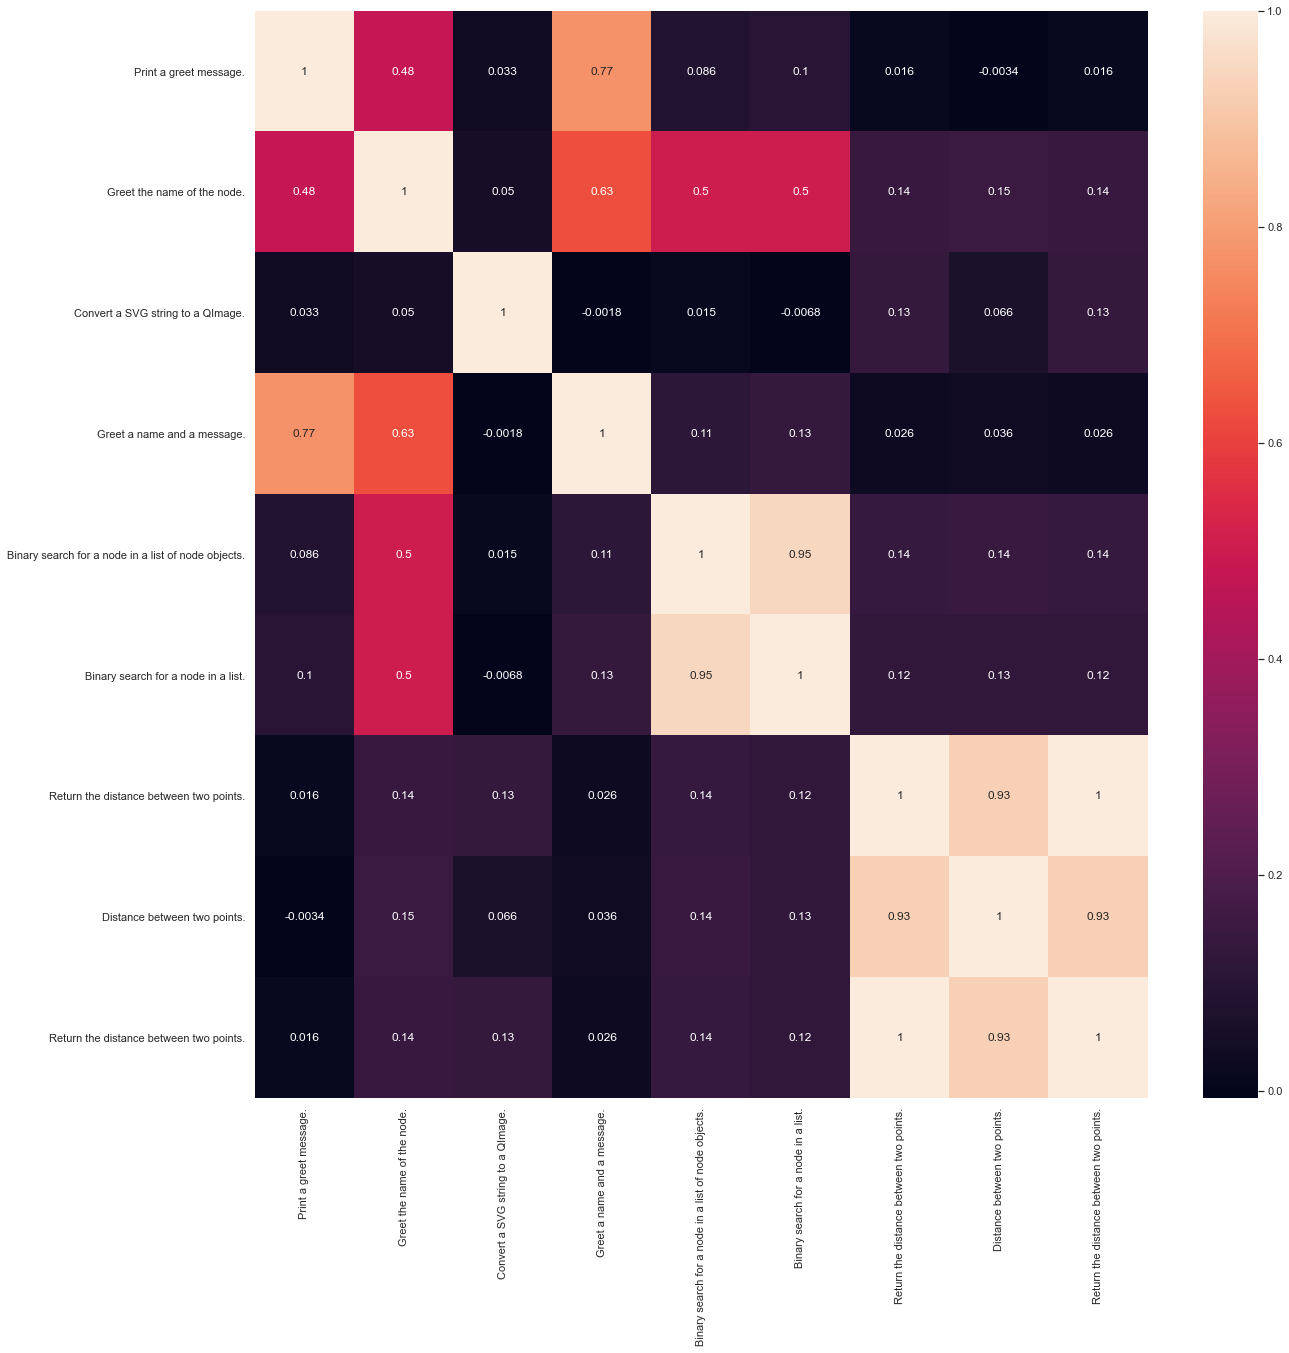

In [10]:
sims = cosine_sims(embeddings)
df = pd.DataFrame(sims, index=summaries, columns=summaries)
df

import seaborn as sns
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(df, annot=True)

In [11]:
sims.min(), sims.mean(), sims.max()

(-0.006768052466213703, 0.3303488703691803, 1.0)

In [12]:
# Ändringar att analysera...
# Verkar det som att semantic similarity kan användas för att upptäcka ändringar
# som hade behövt uppdatera dokumentationen?
# Beror ju dock även på vad som står i dokumentationen...


In [13]:
from loader import load

In [14]:
data = load('funcdata_no_methods.pickle')
keys = list(data.keys())

# Number of code changes to include
size = 20

code_changes = []
for key in keys:
    changes = list(data[key])
    for change in data[key]:
        code_changes.append(change)

print(len(code_changes))
code_changes = code_changes[:size]
print(len(code_changes))


1248
20


In [15]:
from tqdm import tqdm
summaries = []
for i in tqdm(range(len(code_changes))):
    add_summary(code_changes[i])
summaries[:3]

100%|██████████| 20/20 [00:20<00:00,  1.00s/it]


['Invoke a command with a sequence of tokens.',
 'Invoke a command with a sequence of tokens.',
 'Invoke a function with the given arguments.']

In [16]:
embeddings = sbert.encode(summaries)

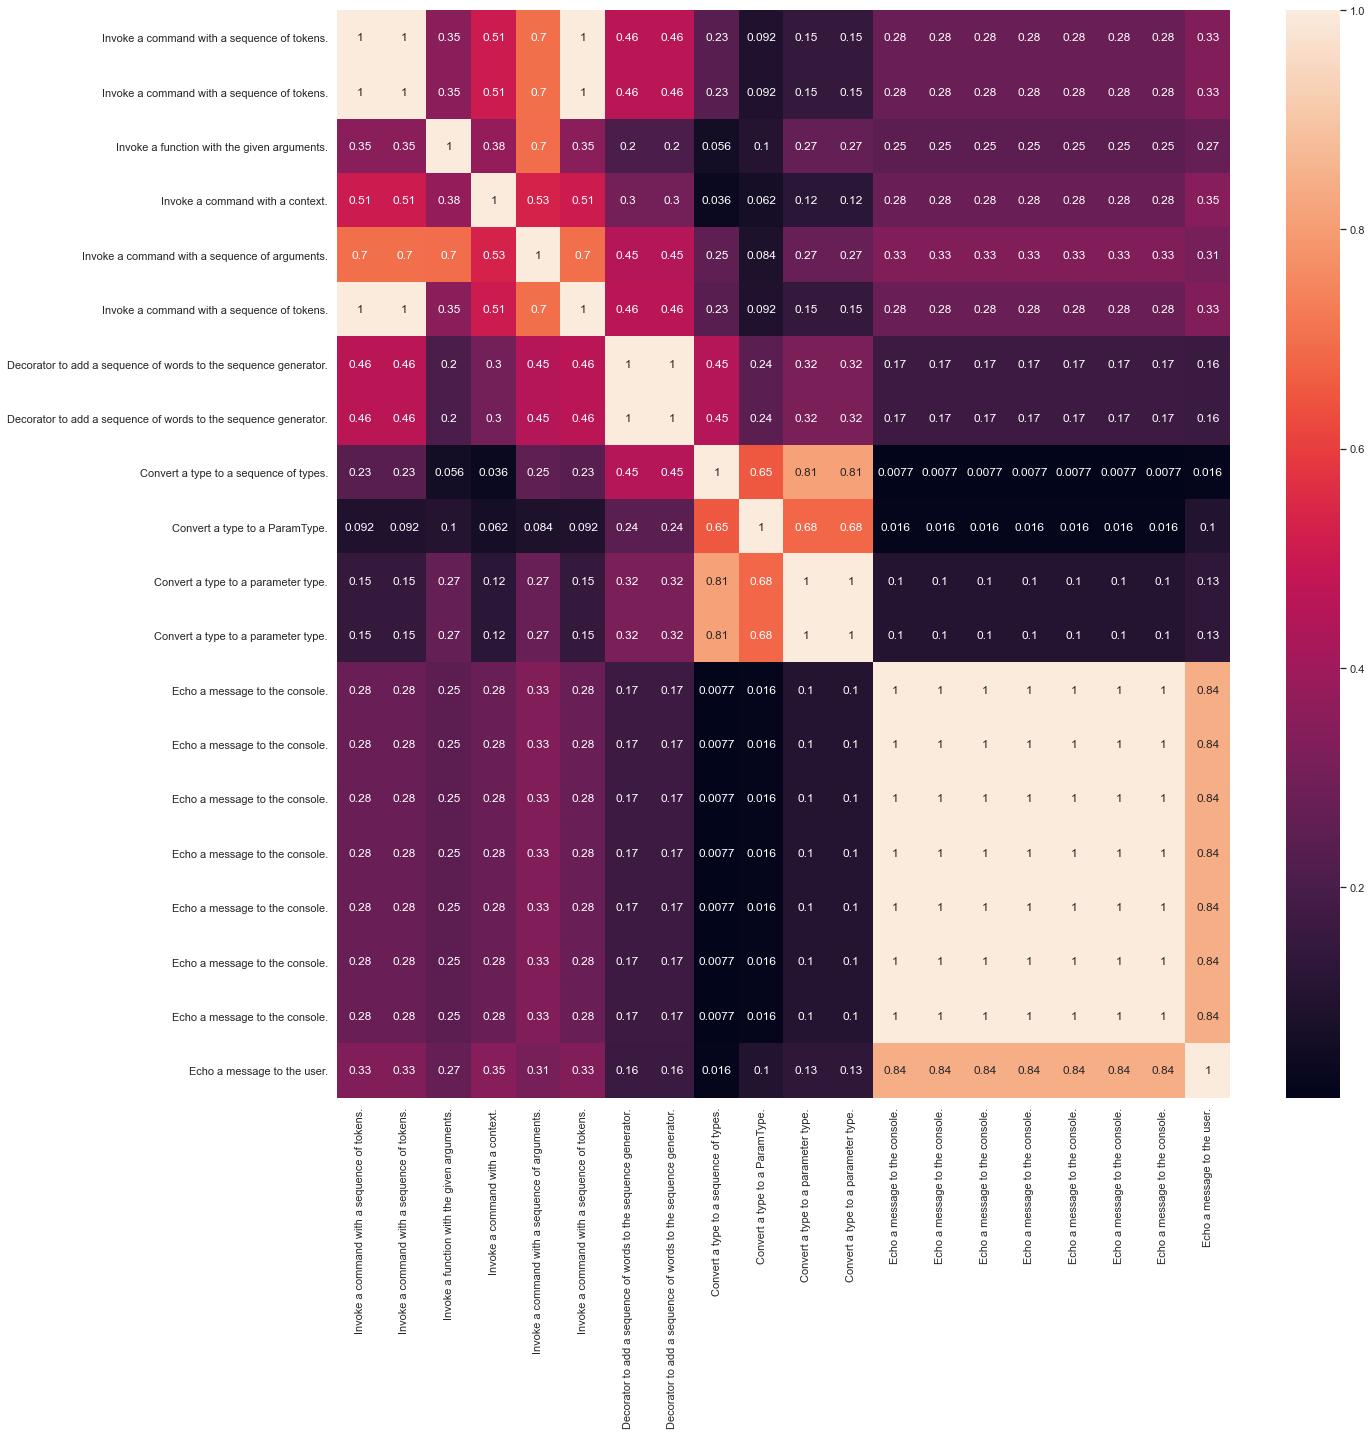

In [17]:
sims = cosine_sims(embeddings)
df = pd.DataFrame(sims, index=summaries, columns=summaries)
df

import seaborn as sns
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(df, annot=True)

In [18]:
signatures = [x.split('\n')[0] for x in code_changes]
for x in zip(signatures, summaries):
    print(x)

('def invoke(*args, **kwargs):', 'Invoke a command with a sequence of tokens.')
('def invoke(*args, **kwargs):', 'Invoke a command with a sequence of tokens.')
('def invoke(*args, **kwargs):', 'Invoke a function with the given arguments.')
('def invoke(*args, **kwargs):', 'Invoke a command with a context.')
('def invoke(*args, **kwargs):', 'Invoke a command with a sequence of arguments.')
('def invoke(*args, **kwargs):', 'Invoke a command with a sequence of tokens.')
('def decorator(f):', 'Decorator to add a sequence of words to the sequence generator.')
('def decorator(f):', 'Decorator to add a sequence of words to the sequence generator.')
('def convert_type(ty, default=None):', 'Convert a type to a sequence of types.')
('def convert_type(ty, default=None):', 'Convert a type to a ParamType.')
('def convert_type(ty, default=None):', 'Convert a type to a parameter type.')
('def convert_type(ty, default=None):', 'Convert a type to a parameter type.')
('def echo(message=None, file=None, 

In [19]:
for c in code_changes[:6]:
    print(c)

def invoke(*args, **kwargs):
    (self, callback) = args[:2]
    ctx = self
    if isinstance(callback, Command):
        other_cmd = callback
        callback = other_cmd.callback
        ctx = Context(other_cmd, info_name=other_cmd.name, parent=self)
        if callback is None:
            raise TypeError('The given command does not have a callback that can be invoked.')
        for param in other_cmd.params:
            if param.name not in kwargs and param.expose_value:
                kwargs[param.name] = param.get_default(ctx)
    args = args[2:]
    with augment_usage_errors(self):
        with ctx:
            return callback(*args, **kwargs)
def invoke(*args, **kwargs):
    (self, callback) = args[:2]
    if isinstance(callback, Command):
        callback = callback.callback
        if callback is None:
            raise TypeError('The given command does not have a callback that can be invoked.')
    args = args[2:]
    if getattr(callback, '__click_pass_context__', False):
 